In [1]:
from dataclasses import dataclass, field
from pathlib import Path
import os

os.environ['LANDSLIDE_DENSITY_THRESHOLD'] = (
    '0.0000001'  # the percentage landslide required for an image to be classified as landslided (check landnet.config module)
)

from pytorch_grad_cam import (
    GradCAM,
    HiResCAM,
    ScoreCAM,
    GradCAMPlusPlus,
    AblationCAM,
    XGradCAM,
    EigenCAM,
    RandomCAM,
    LayerCAM,
    GradCAMElementWise,
    EigenGradCAM,
    GuidedBackpropReLUModel,
)
from pytorch_grad_cam.guided_backprop import GuidedBackpropReLUasModule
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.image import (
    show_cam_on_image, deprocess_image, preprocess_image
)
from pytorch_grad_cam.sobel_cam import sobel_cam
from pytorch_grad_cam.utils.find_layers import replace_all_layer_type_recursive
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget, ClassifierOutputTarget
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst
from torch import nn
import torch
import numpy as np
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from IPython.display import clear_output
from sklearn.decomposition import PCA

from landnet.config import MODELS_DIR, FIGURES_DIR
from landnet.enums import Mode, GeomorphometricalVariable, Architecture
from landnet.modelling import torch_clear
from landnet.modelling.classification.lightning import LandslideImageClassifier
from landnet.modelling.classification.models import get_architecture
from landnet.modelling.classification.dataset import (
    ConcatLandslideImageClassification,
    LandslideImageClassification,
)
from landnet.features.grids import get_grid_for_variable, Grid
from landnet.features.tiles import TileConfig, TileSize
from landnet.modelling.dataset import get_default_transform
from landnet.typing import TuneSpace
from landnet.utils import geomorphometrical_variables_from_file

clear_output()

In [2]:
tile_config = TileConfig(TileSize(100, 100), overlap=0)
model_config: TuneSpace = {
    'batch_size': 1,
    'learning_rate': 0.000001,
    'tile_config': tile_config,
}


@dataclass
class Model:
    checkpoint_path: Path
    name: str
    variables: list[GeomorphometricalVariable] = field(init=False)
    grids: dict[Mode, list[Grid]] = field(init=False, default_factory=dict)
    datasets: dict[Mode, list[tuple[torch.Tensor, torch.Tensor]]] = field(init=False, default_factory=dict)
    classifier: LandslideImageClassifier = field(init=False)
    is_setup: bool = field(init=False, default=False)

    def setup(self):
        assert self.checkpoint_path.exists()
        variables_path = self.checkpoint_path.parent.parent.parent / 'geomorphometrical_variables'
        assert variables_path.exists()
        self.variables = geomorphometrical_variables_from_file(variables_path)
        self.set_classifier()
        self.get_grids_and_datasets()
        clear_output()
        self.is_setup = True

    def set_classifier(self):
        self.classifier = LandslideImageClassifier.load_from_checkpoint(
            self.checkpoint_path,
            model=get_architecture(Architecture('convnext'))(
                len(self.variables), Mode.INFERENCE
            )
        )
    
    def get_grids_and_datasets(self):
        for mode in (Mode.TEST,):
            self.grids[mode] = [
                get_grid_for_variable(
                    variable,
                    tile_config=tile_config,
                    mode=mode,
                )
                for variable in self.variables
            ]
            dataset = ConcatLandslideImageClassification(
                landslide_images=[
                    LandslideImageClassification(
                        grid,
                        mode,
                        transform=get_default_transform(),
                    )
                    for grid in self.grids[mode]
                ],
                augment_transform=None,
            )
            dataloader = DataLoader(
                dataset,
                batch_size=1,
                num_workers=4,
                shuffle=False,
                prefetch_factor=4,
                persistent_workers=True,
                pin_memory=True,
            )
            self.datasets[mode] = list(dataloader)
        
        

models = [
    Model(checkpoint_path=(
    MODELS_DIR
    / 'convnext_100x100_5vars/convnext_100x100_5vars/2025-06-27_16-46-08/TorchTrainer_05f6ed3b_2_batch_size=2,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-27_17-10-49/checkpoint_000008/checkpoint.ckpt'),
    name='model 1'),
    Model(checkpoint_path=(
        MODELS_DIR
    / 'convnext_100x100_10vars/convnext_100x100_10vars/TorchTrainer_cf20a57d_5_batch_size=4,learning_rate=0.0000,tile_config=ref_ph_c793cfd2_2025-06-28_00-30-26/checkpoint_000016/checkpoint.ckpt'),
    name='model 2'),
]
models[1].setup()

In [3]:
def get_all_conv2d_layers(model):
    conv_layers = {}

    def recurse(module, prefix=''):
        for name, layer in module.named_children():
            full_name = f'{prefix}.{name}' if prefix else name
            if isinstance(layer, nn.Conv2d):
                conv_layers[full_name] = layer
            elif isinstance(layer, nn.Module):  # If it's a module, recurse
                recurse(layer, full_name)

    recurse(model)
    return conv_layers

def save_activations_and_gradients(cam, out_dir: Path, index: int = 0, count: int = 50, split: bool = True):
    os.makedirs(out_dir, exist_ok=True)
    activations = cam.activations_and_grads.activations[index].squeeze(0)
    gradients = cam.activations_and_grads.gradients[index].squeeze(0)
    for matrices, name, cmap in zip((activations, gradients), ('activations', 'gradients'), ('viridis', 'Grays')):
        num_channels = matrices.shape[0]
        num_arrs = min(count, num_channels)
        for i, matrix in enumerate(matrices):
            fig, ax = plt.subplots()
            if i > num_arrs:
                break
            arr = matrix.cpu().numpy()
            ax.imshow(arr, cmap=cmap)
            ax.axis('off')  # Hide axis
            plt.tight_layout()
            plt.savefig(
                out_dir / f'{name}_{i}_{matrix.shape}.png',
                dpi=300,
                transparent=True,
                bbox_inches='tight',
                pad_inches=0,
            )
            plt.close()

class BinaryGuidedBackpropReLUModel(GuidedBackpropReLUModel):
    def __init__(self, model, device):
        super().__init__(model, device)

    def __call__(self, input_img):
        replace_all_layer_type_recursive(self.model,
                                         nn.ReLU,
                                         GuidedBackpropReLUasModule())


        input_img = input_img.to(self.device)

        input_img = input_img.requires_grad_(True)

        loss = self.forward(input_img)
        loss.backward(retain_graph=True)

        output = input_img.grad.cpu().data.numpy()
        output = output[0, :, :, :]
        output = output.transpose((1, 2, 0))

        replace_all_layer_type_recursive(self.model,
                                         GuidedBackpropReLUasModule,
                                         nn.ReLU())

        return output


def get_guided_backprop(classifier, input_tensor, cam):
    gb_model = BinaryGuidedBackpropReLUModel(model=classifier, device=classifier.device)
    gb = gb_model(input_tensor)
    cam_mask = np.repeat(np.expand_dims(grayscale_cam, 2), gb.shape[2], 2)
    cam_gb = deprocess_image(cam_mask * gb)
    return cam_gb[:, :, :3]


class LogitBinaryClassifierOutputTarget:
    def __init__(self, category):
        self.category = category

    def __call__(self, model_output):
        model_output = model_output.sigmoid()
        if self.category == 1:
            sign = 1
        else:
            sign = -1
        return model_output * sign

19849
PASSED: True The confidence increase when removing 60% of the image: -0.907, for sobel: -0.807, for ROADCombined: 0.000
19945
PASSED: True The confidence increase when removing 60% of the image: -0.993, for sobel: -0.987, for ROADCombined: 0.000
19912
PASSED: False The confidence increase when removing 60% of the image: -0.894, for sobel: -0.944, for ROADCombined: 0.000
18879
PASSED: True The confidence increase when removing 60% of the image: -0.997, for sobel: -0.517, for ROADCombined: 0.000


/tmp/ipykernel_297849/2882629938.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


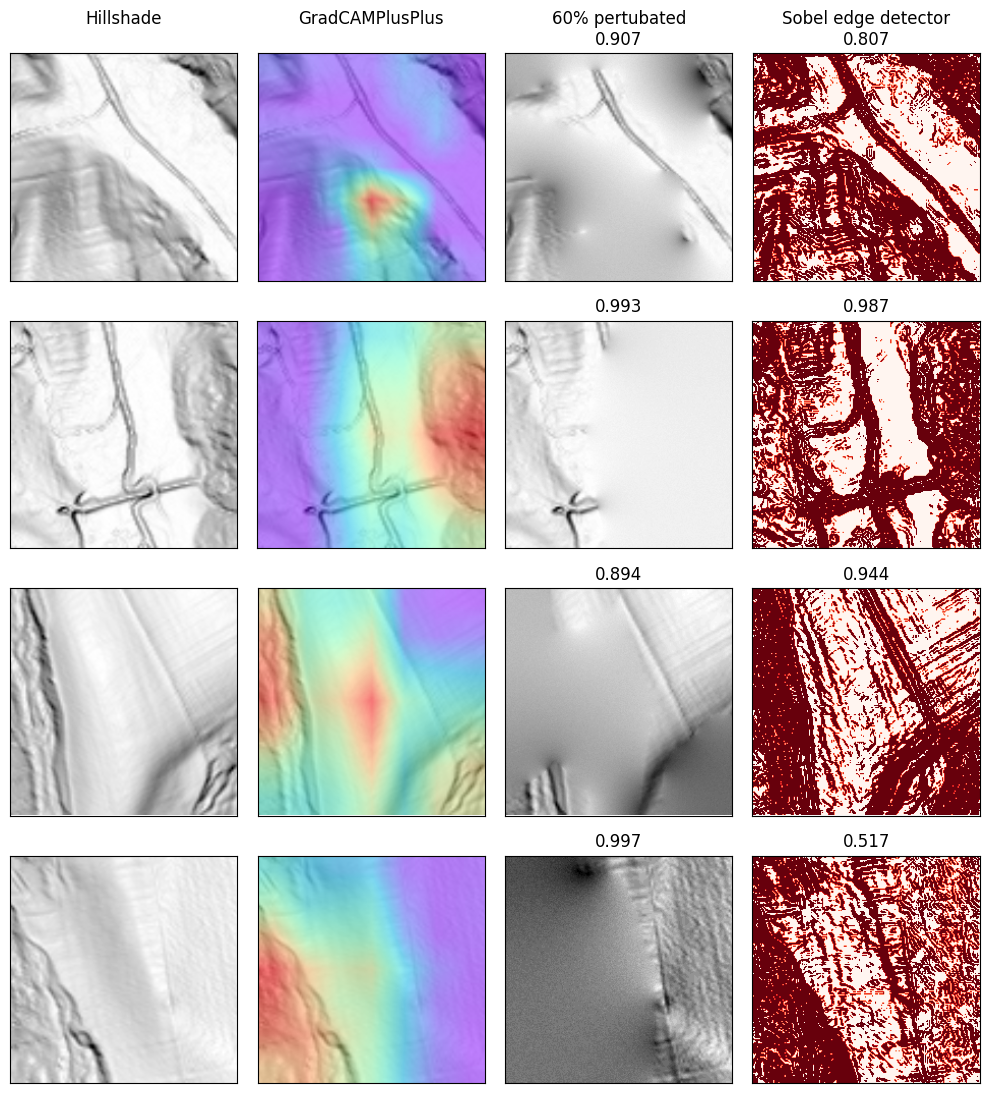

In [5]:
# Compares different GradCAM methods

# The index of the tiles to select from the test area

# Good examples
# sample_indices = [297, 265, 392, 360, 241, 164, 90, 357]

# Low landslide density
sample_indices = [156, 5, 271, 317, 359, 194, 292, 231, 174, 232, 286]
sample_indices = [292, 231, 174, 232]


# False negatives
# sample_indices = [379, 293, 121, 329, 363, 342]

percentiles = [40]
cam_metric = ROADMostRelevantFirst
# cam_metric_combined = ROADCombined(percentiles=[20, 40, 60, 80])

n_samples = len(sample_indices)
n_percentiles = len(percentiles)

grid_fig = plt.figure(figsize=(10, 20))
grid_fig.set_tight_layout(True)

nrows = n_samples
ncols = n_percentiles + 1 + 1 + 1  # gradcam + sobel + hillshade aswell

grid = ImageGrid(
    grid_fig,
    111,
    nrows_ncols=(nrows, ncols),
    axes_pad=(0.2, 0.4),
    share_all=True,
)
grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

fontdict = {'fontsize': 12}
method = GradCAMPlusPlus
model = models[1]
layers = get_all_conv2d_layers(model.classifier)
layer_names = list(layers)
layer_name = layer_names[-1]
layer = layers[layer_name]
target_layers = [layer]

def compare_to_sobel(img, percentile, model):
    img = np.repeat(img, 3, 2)
    sobel_cam_grayscale = sobel_cam(np.uint8(img * 255))
    thresholded_cam = sobel_cam_grayscale < np.percentile(sobel_cam_grayscale, percentile)
    print(thresholded_cam.sum())
    cam_metric = CamMultImageConfidenceChange()
    scores, visualizations = cam_metric(input_tensor, [thresholded_cam], targets, model, return_visualization=True)
    score = scores[0]
    visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
    # visualization = deprocess_image(visualization)
    #print(f"The confidence increase with sobel: {score}")
    return thresholded_cam, score

with method(model=model.classifier, target_layers=target_layers) as cam:
    targets = [LogitBinaryClassifierOutputTarget(1)]
    for i, sample_index in enumerate(sample_indices):
        sample = model.datasets[Mode.TEST][sample_index][0]
        hillshade = sample[0, 0].numpy()
        hillshade_index = i * ncols
        input_tensor = sample.to(model.classifier.device)
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cams[0, :]
        grid[hillshade_index].imshow(hillshade, cmap='binary')
        if i == 0:
            grid[hillshade_index].set_title('Hillshade\n', fontdict=fontdict)
        for j, percentile in enumerate(percentiles, start=1):
            cam_index = hillshade_index + j
            cam_metric = ROADMostRelevantFirst(percentile=percentile)
            scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model.classifier, return_visualization=True)
            score = scores[0]
            # road_combined_score = cam_metric_combined(input_tensor, grayscale_cams, targets, model.classifier)[0]
            road_combined_score = 0
            visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
            visualization = deprocess_image(visualization)
            sobel, sobel_score = compare_to_sobel(input_tensor[0, :1].cpu().numpy().transpose((1, 2, 0)), percentile, model.classifier)
            print(f"PASSED: {score < sobel_score} The confidence increase when removing {100-percentile}% of the image: {score:.3f}, for sobel: {sobel_score:.3f}, for ROADCombined: {road_combined_score:.3f}")

            
            grid[cam_index].imshow(hillshade, cmap='binary')
            grid[cam_index].imshow(grayscale_cam, cmap='rainbow', alpha=0.5)
            grid[cam_index + 1].imshow(visualization[:, :, 0], cmap='binary')
            grid[cam_index + 1].set_title(f'{-score:.3f}', fontdict=fontdict)
            grid[cam_index + 2].imshow(sobel, cmap='Reds_r')
            grid[cam_index + 2].set_title(f'{-sobel_score:.3f}', fontdict=fontdict)
            if i == 0:
                grid[cam_index].set_title(method.__name__+'\n', fontdict=fontdict)
                title = '\n'.join ([f'{100 - percentile}% pertubated', grid[cam_index + 1].get_title()])
                grid[cam_index + 1].set_title(title, fontdict=fontdict)
                
                title = '\n'.join (['Sobel edge detector', grid[cam_index + 2].get_title()])
                grid[cam_index + 2].set_title(title, fontdict=fontdict)
plt.tight_layout()
grid_fig.savefig(FIGURES_DIR / f'gradcam_vs_sobel.png', dpi=300, bbox_inches='tight')
#guided_backprop_fig.savefig(FIGURES_DIR / f'guidedbackpropcam_comparison_{method.__name__}.png', dpi=300, bbox_inches='tight')